# Toy Example: Iris Dataset

In this notebook, we explore the application of TGT in context of a toy dataset, the Iris dataset. At a high level, we will first reduce the dimensions of the dataset, then cluster the points, and finally use TGT to explain the differences in the 3 clusters. We will also compare these explanations with DBM (difference between the means) of the clusters.

In [1]:
# autoreload everything everytime
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import pdb

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

import plotly
import plotly.graph_objects as go

from IPython.display import display

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import tgt
import vae
import utils

## Get Data
We will use `scikit-learn`'s in built `datasets` module to load the dataset.

In [3]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data
Y = iris.target.reshape(-1, 1)
X.shape, Y.shape

((150, 4), (150, 1))

In [4]:
# scale the data and labels
data_scaler = MinMaxScaler().fit(X)
X_scaled = data_scaler.transform(X)

In [5]:
# torch tensors of data
X_pt_scaled = torch.from_numpy(X_scaled).type(torch.float)
Y_pt = torch.from_numpy(Y).type(torch.float)

## Reduce Dimensions
Here, we will reduce dimensions by training a Variational AutoEncoder (VAE). We will compare the output of the VAE with that of PCA just to ensure that the VAE is giving comparable output and therefore reducing dimensions in a meaningful way.

In [6]:
# how many dimensions to keep
n_dim = 2

### PCA

In [7]:
# sklearn pca
pca_sklearn = PCA(
    n_components=n_dim,
    random_state=42,
)
X_pca_sklearn = pca_sklearn.fit_transform(X_scaled)

In [8]:
# torch pca
(U, S, V) = torch.pca_lowrank(
    A=X_pt_scaled.unsqueeze(0),
#     q=4,
    center=True,
    niter=25,
)
X_pca_pt = torch.matmul(X_pt_scaled, V[0, :, :n_dim]).squeeze()

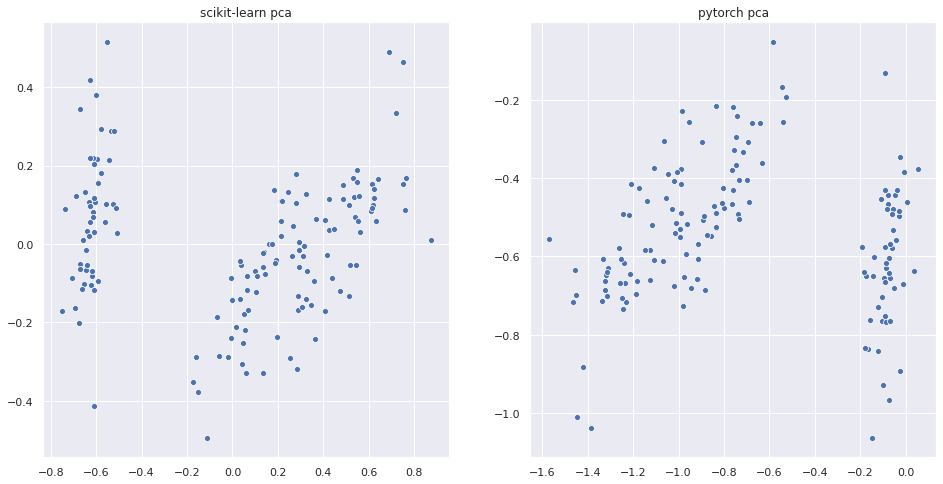

In [9]:
# visualize pca from sklearn and pca from pytorch
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.scatterplot(
    x=X_pca_sklearn[:, 0],
    y=X_pca_sklearn[:, 1],
    ax=axes[0],
)
axes[0].set_title('scikit-learn pca')

sns.scatterplot(
    x=X_pca_pt[:, 0],
    y=X_pca_pt[:, 1],
    ax=axes[1],
)
axes[1].set_title('pytorch pca')

plt.show()

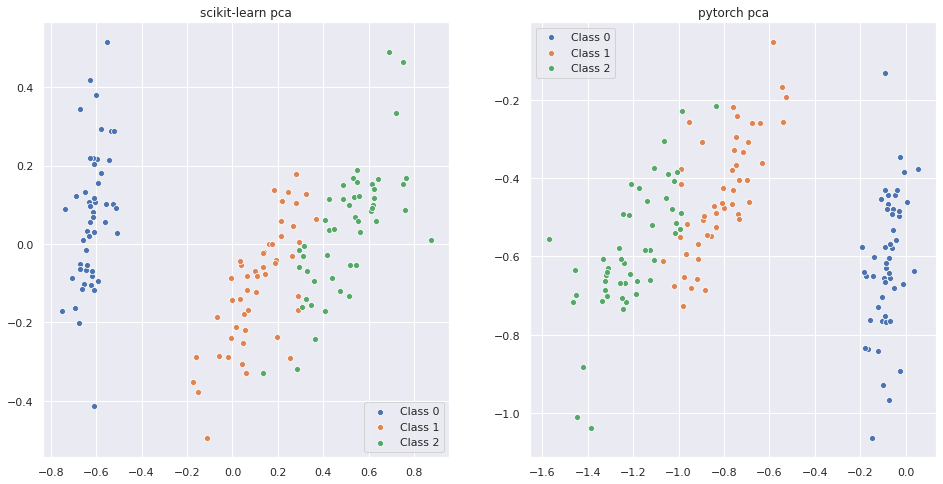

In [10]:
# visualize pca from sklearn and pca from pytorch, colored by true class labels
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for ci in np.unique(Y):
    sns.scatterplot(
        x=X_pca_sklearn[(Y==ci).reshape(-1,), 0],
        y=X_pca_sklearn[(Y==ci).reshape(-1,), 1],
        ax=axes[0],
        label=f'Class {ci}',
    )
    sns.scatterplot(
        x=X_pca_pt[(Y==ci).reshape(-1,), 0],
        y=X_pca_pt[(Y==ci).reshape(-1,), 1],
        ax=axes[1],
        label=f'Class {ci}',
    )

axes[0].set_title('scikit-learn pca')
axes[1].set_title('pytorch pca')

plt.show()

### VAE
In this section we will train a VAE and use it to reduce dimensions in the data

In [63]:
# train args
batch_size = 4
num_epochs = 50
log_interval_epochs = 5
learning_rate = 0.001
device = torch.device('cpu')

In [67]:
# init dataset, model, optimizer
dataset = utils.IrisDataset(
#     transform=data_scaler.transform,
)

train_loader = DataLoader(
    shuffle=True,
    dataset=dataset,
    batch_size=batch_size,
)

model = vae.VAE(
    input_ndim=4, 
    output_ndim=n_dim,
    encode_layer_sizes=(32, 16), 
    decode_layer_sizes=(16, 32)
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [68]:
# run training (code block from https://github.com/pytorch/examples/blob/master/vae/main.py#L85)
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_data, batch_labels in train_loader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(batch_data)
        
        loss = vae.loss_function(recon_batch, batch_data.view(-1, X_pt_scaled.shape[1]), mu, logvar)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()

    if epoch % log_interval_epochs == 0:
        print('Epoch: {:4d} Average loss: {:.4f}'.format(
            epoch,
            train_loss / len(train_loader.dataset)),
            end='\r',
         )

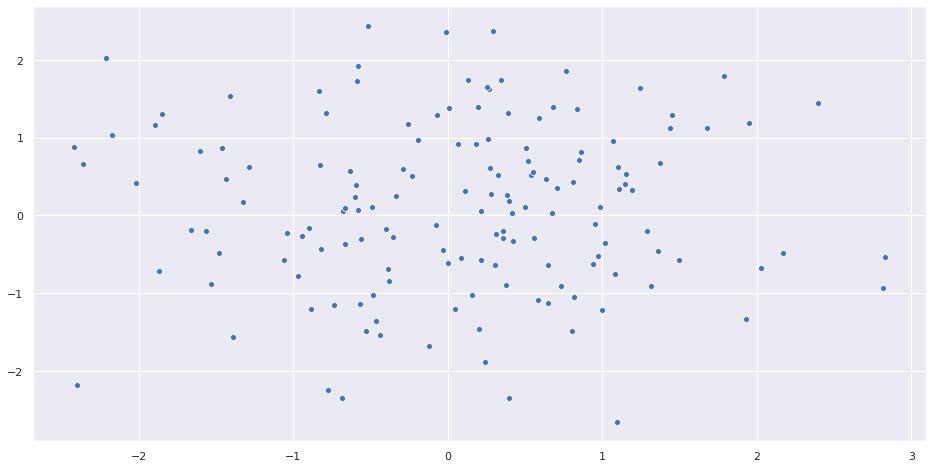

In [69]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.scatterplot(
    x=X_vae_pt[:, 0],
    y=X_vae_pt[:, 1],
    ax=ax,
)
plt.show()

In [20]:
# get lwo dim rep for dataset
with torch.no_grad():
    mu, logvar = model.encode(X_pt_scaled)
    X_vae_pt = model.reparameterize(mu, logvar)

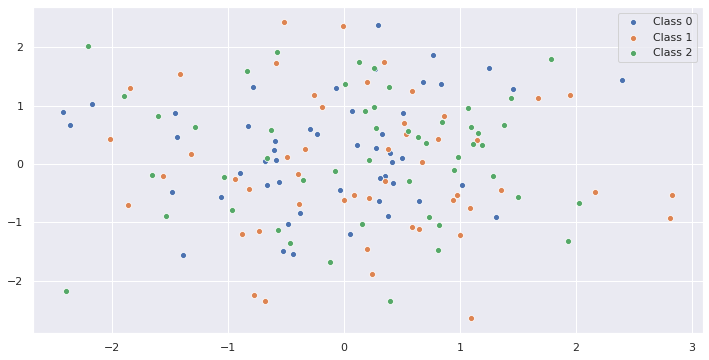

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

for ci in np.unique(Y):
    sns.scatterplot(
        x=X_vae_pt[Y.reshape(-1,)==ci, 0],
        y=X_vae_pt[Y.reshape(-1,)==ci, 1],
        ax=ax,
        label=f'Class {ci}',
    )

plt.show()

In [167]:
# visualize how well torch vae worked
fig = go.Figure()

for ci in np.unique(Y):
    fig.add_trace(
        go.Scatter(
            x=X_vae_pt[Y==ci, 0],
            y=X_vae_pt[Y==ci, 1],
            mode='markers',
            name=f'Class {ci}',
        )
    )

fig.show()

## Cluster
Now, we'll run clustering on the low dimensional representation of data

In [36]:
# train kmeans on pca reduced data
kmeans = KMeans(
    n_clusters=3,
    random_state=42,
).fit(X_pca_pt.numpy())
h,c,v = homogeneity_completeness_v_measure(Y.squeeze(), kmeans.labels_)
print(f'Homogeneity = {h}\nCompleteness = {c}\nVscore = {v}')

Homogeneity = 0.7364192881252849
Completeness = 0.7474865805095326
Vscore = 0.7419116631817838


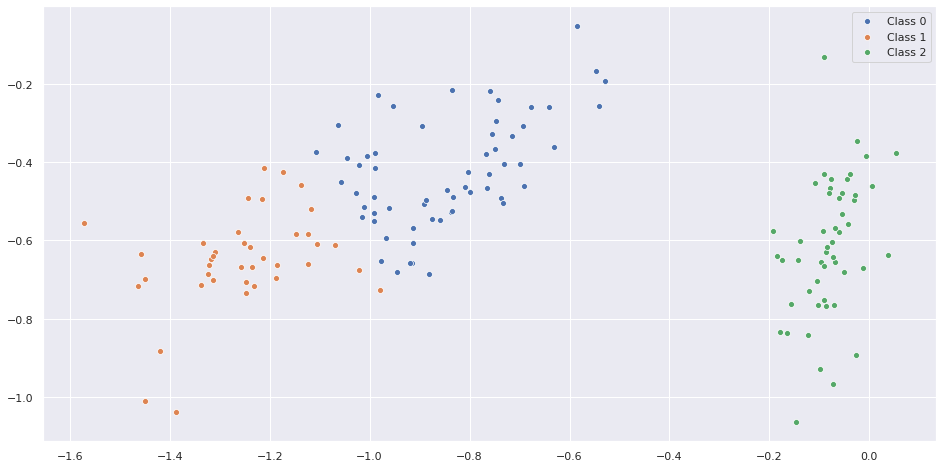

In [37]:
# visualize clusters - true classes vs clusters assigned
fig, ax = plt.subplots(figsize=(16, 8))

for ci in np.unique(kmeans.labels_):
    sns.scatterplot(
        x=X_pca_pt[kmeans.labels_==ci, 0],
        y=X_pca_pt[kmeans.labels_==ci, 1],
        ax=ax,
        label=f'Class {ci}',
    )

plt.show()

In [178]:
# visualize clusters
fig = go.Figure()

for ci in np.unique(kmeans.labels_):
    fig.add_trace(
        go.Scatter(
            x=X_pca_pt[kmeans.labels_==ci, 0],
            y=X_pca_pt[kmeans.labels_==ci, 1],
            mode='markers',
            name=f'Class {ci}',
        )
    )

fig.show()

In [38]:
# train kmeans on vae reduced data
kmeans = KMeans(
    n_clusters=3,
    random_state=42,
).fit(X_vae_pt.numpy())
h,c,v = homogeneity_completeness_v_measure(Y.squeeze(), kmeans.labels_)
print(f'Homogeneity = {h}\nCompleteness = {c}\nVscore = {v}')

Homogeneity = 0.778732331710659
Completeness = 0.792722583434307
Vscore = 0.7856651817981656


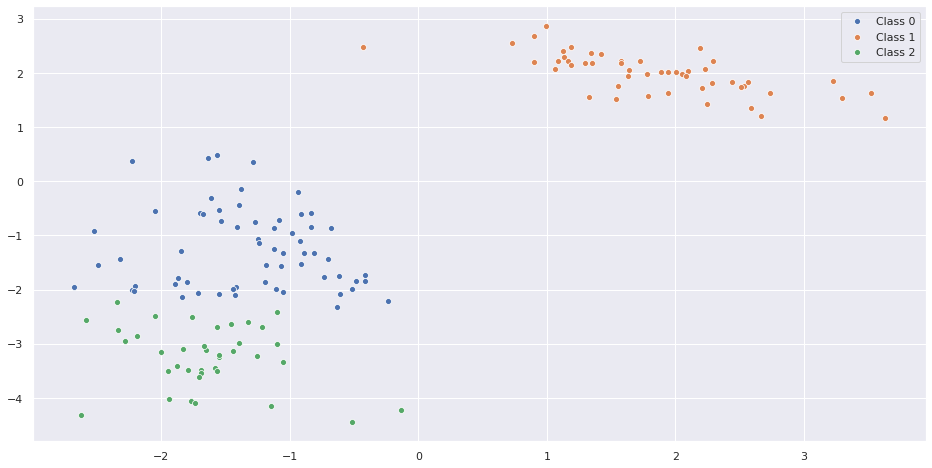

In [39]:
# visualize clusters
fig, ax = plt.subplots(figsize=(16, 8))

for ci in np.unique(kmeans.labels_):
    sns.scatterplot(
        x=X_vae_pt[kmeans.labels_==ci, 0],
        y=X_vae_pt[kmeans.labels_==ci, 1],
        ax=ax,
        label=f'Class {ci}',
    )

plt.show()

## Explain

In [183]:
# convert to dataframes for better understanding features
X_df = pd.DataFrame(
    data=X,
    columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
)
print(X_df.shape)
X_df.head()

(150, 4)


,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### DBM

In [184]:
# difference between each pair of classes (actual)
print('DBM Class 0 and Class 1', end='\n'+'='*88)
dbm01 = X_df.loc[Y==0, :].mean() - X_df.loc[Y==1, :].mean()
sort_idx01 = dbm01.abs().sort_values(ascending=False).index
display(dbm01.reindex(sort_idx01))

print('DBM Class 1 and Class 2', end='\n'+'='*88)
dbm12 = X_df.loc[Y==1, :].mean() - X_df.loc[Y==2, :].mean()
sort_idx12 = dbm12.abs().sort_values(ascending=False).index
display(dbm12.reindex(sort_idx12))

print('DBM Class 2 and Class 0', end='\n'+'='*88)
dbm20 = X_df.loc[Y==2, :].mean() - X_df.loc[Y==0, :].mean()
sort_idx20 = dbm20.abs().sort_values(ascending=False).index
display(dbm20.reindex(sort_idx20))

DBM Class 0 and Class 1

petal_length   -2.798
petal_width    -1.080
sepal_length   -0.930
sepal_width     0.658
dtype: float64

DBM Class 1 and Class 2

petal_length   -1.292
petal_width    -0.700
sepal_length   -0.652
sepal_width    -0.204
dtype: float64

DBM Class 2 and Class 0

petal_length    4.090
petal_width     1.780
sepal_length    1.582
sepal_width    -0.454
dtype: float64

In [188]:
# difference between each pair of classes (vae reduced)
print('DBM Class 0 and Class 1', end='\n'+'='*88)
dbm01 = X_df.loc[kmeans.labels_==0, :].mean() - X_df.loc[kmeans.labels_==1, :].mean()
sort_idx01 = dbm01.abs().sort_values(ascending=False).index
display(dbm01.reindex(sort_idx01))

print('DBM Class 1 and Class 2', end='\n'+'='*88)
dbm12 = X_df.loc[kmeans.labels_==1, :].mean() - X_df.loc[kmeans.labels_==2, :].mean()
sort_idx12 = dbm12.abs().sort_values(ascending=False).index
display(dbm12.reindex(sort_idx12))

print('DBM Class 2 and Class 0', end='\n'+'='*88)
dbm20 = X_df.loc[kmeans.labels_==2, :].mean() - X_df.loc[kmeans.labels_==0, :].mean()
sort_idx20 = dbm20.abs().sort_values(ascending=False).index
display(dbm20.reindex(sort_idx20))

DBM Class 0 and Class 1

petal_length    4.144383
petal_width     1.802936
sepal_length    1.647191
sepal_width    -0.425872
dtype: float64

DBM Class 1 and Class 2

petal_length   -2.822906
petal_width    -1.099283
sepal_length   -0.909094
sepal_width     0.671396
dtype: float64

DBM Class 2 and Class 0

petal_length   -1.321477
sepal_length   -0.738097
petal_width    -0.703653
sepal_width    -0.245524
dtype: float64

### EGPLDR

In [189]:
# calculate clusterwise means in low dim rep as well as original high dim space
X_clusterwise_means_highdim = torch.stack([
    X_pt[kmeans.labels_==0, :].mean(axis=0),
    X_pt[kmeans.labels_==1, :].mean(axis=0),
    X_pt[kmeans.labels_==2, :].mean(axis=0),
])

X_clusterwise_means_lowdim = torch.stack([
    X_vae_pt[kmeans.labels_==0, :].mean(axis=0),
    X_vae_pt[kmeans.labels_==1, :].mean(axis=0),
    X_vae_pt[kmeans.labels_==2, :].mean(axis=0),
])

### Train method 1

In [192]:
# get deltas1
deltas1 = tgt.transitive_global_translations(
    model,
    low_dim_group_means=X_clusterwise_means_lowdim,
    high_dim_group_means=X_clusterwise_means_highdim,
#     tol=1e-5,
#     clip_val=5,
#     min_epochs=5000,
#     stopping_epochs=5000,
    verbose=True,
)
deltas1

[tensor([[-0.1748,  0.1742, -0.1750, -0.1750]], requires_grad=True),
 tensor([[ 0.1277, -0.1283,  0.1275,  0.1275]], requires_grad=True)]

### Train method 2

In [274]:
# get deltas2
deltas2 = tgt.transitive_global_translations_experimental(
    dim_reducer=model,
    low_dim_group_means=X_clusterwise_means_lowdim,
    high_dim_group_means=X_clusterwise_means_highdim,
    verbose=True,
)
deltas2

TGT(
  (deltas): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 1x4]
      (1): Parameter containing: [torch.FloatTensor of size 1x4]
  )
)

## Test how many points from class 0 go to class 1 when delta is applied

In [275]:
# get vae embedding for points in class 0
with torch.no_grad():
    mu, logvar = model.encode(X_pt[Y==0])
    class0_vae = model.reparameterize(mu, logvar)

# add delta and see how many points go to class 1
with torch.no_grad():
    mu, logvar = model.encode(X_pt[Y==0] + deltas1[0])
    class0_delta1_vae = model.reparameterize(mu, logvar)

class0_delta1_vae_preds = kmeans.predict(class0_delta1_vae.numpy())
class0_delta1_vae_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [276]:
# get vae embedding for points in class 0
with torch.no_grad():
    mu, logvar = model.encode(X_pt[Y==0])
    class0_vae = model.reparameterize(mu, logvar)

# add delta and see how many points go to class 1
with torch.no_grad():
    mu, logvar = model.encode(X_pt[Y==0] + deltas2(initial_ci=0, target_ci=1).data)
    class0_delta1_vae = model.reparameterize(mu, logvar)

class0_delta1_vae_preds = kmeans.predict(class0_delta1_vae.numpy())
class0_delta1_vae_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

## Test how many points from class 0 go to class 2 when delta is applied

In [277]:
# get vae embedding for points in class 0
with torch.no_grad():
    mu, logvar = model.encode(X_pt[Y==0])
    class0_vae = model.reparameterize(mu, logvar)

# add delta and see how many points go to class 1
with torch.no_grad():
    mu, logvar = model.encode(X_pt[Y==0] + deltas1[1])
    class0_delta1_vae = model.reparameterize(mu, logvar)

class0_delta1_vae_preds = kmeans.predict(class0_delta1_vae.numpy())
class0_delta1_vae_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [284]:
# get vae embedding for points in class 0
with torch.no_grad():
    mu, logvar = model.encode(X_pt[Y==0])
    class0_vae = model.reparameterize(mu, logvar)

# add delta and see how many points go to class 1
with torch.no_grad():
    mu, logvar = model.encode(X_pt[Y==1] + deltas2(initial_ci=1, target_ci=2).data)
    class0_delta1_vae = model.reparameterize(mu, logvar)

class0_delta1_vae_preds = kmeans.predict(class0_delta1_vae.numpy())
class0_delta1_vae_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

works well:
- 0-1
- 1-0
- 2-0
- 2-1

doesnt work well:
- 0-2
- 1-2

In [255]:
num_clusters = X_clusterwise_means_highdim.shape[0]
i, t = np.random.choice(num_clusters, 2, replace = False)
i,t

(2, 0)

In [262]:
import itertools

In [270]:
perms = list(itertools.permutations(range(3), r=2))
# for i in perms: print(i)
perms

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]

In [273]:
fo,bar = perms[0]
bar

1